In [1]:
!mkdir levels

In [45]:
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import random
import importlib
import game
import matplotlib.pyplot as plt
importlib.reload(game)
from copy import deepcopy

In [46]:
class ValueNetwork(nn.Module):
    def __init__(self, input_size=5, output_size=1):
        super(ValueNetwork, self).__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, 512)
        self.linear4 = nn.Linear(512, output_size)

    def forward(self, state):
        state = self.linear1(state)
        state = self.linear2(state)
        state = self.linear3(state)
        state = self.linear4(state)
        return state


In [47]:
class BackwardAgent():
    def __init__(self):
        self.value_network = ValueNetwork()
        self.optimizer = optim.SGD(self.value_network.parameters(), lr=0.01)
        self.loss = nn.MSELoss()
        self.gamma = 0.9
        self.alpha = 0.1
        self.discount = 0.98
        self.eps = 0.1

    # POST: Returns backward trajectory as specified by the paper
    # More precisely returns a list of all board positions visited by the backward agent
    # and the packing order as impled by the backward trajectory
    def backward_trajectory(self, env):
        self.value_network.eval()
        boards = []
        packing_order = []
        state, reward, done = env.state(gamma=self.gamma)

        while not done:
          # append current board
          boards = boards + [deepcopy(env.board)]
          # find next action
          [action, _, _, _, _, _] = self.policy(env)
          if action is None: # agent is stuck and can't move
            done = 1
            continue
          else:
            if np.random.rand() < self.eps:
              action = random.choice(env.legal_moves())
              assert (action != None)
            state, reward, done = env.play(action, gamma=self.gamma)
            print(state)
        self.value_network.train()
        return boards, packing_order

    def print_trajectory(boards):
      util = game.Game(disable_prints=False)
      for board in boards:
        util.print_board(board)

    def policy(self, env):
        legal_moves = env.legal_moves()
        if len(legal_moves) == 0: # Agent is stuck angamma=Nond can't move
            return [None, None, None, None, None, None]

        value_moves = []
        for char in legal_moves:
            state, reward, done = env.step(char, gamma=self.gamma)
            state_tensor = torch.tensor(state)
            value_moves.append([char, state, state_tensor, self.value_network(state_tensor), reward, done])
        return max(value_moves, key=lambda x:x[3])

    def random_policy(self, env):
      legal_moves = env.legal_moves()
      if len(legal_moves)==0:
        return None
      else:
        return random.choice(legal_moves)

    def random_baseline(self, number_of_episodes, start, end, plot=True):
      wins=[0 for i in range(number_of_episodes)]
      moves=[]
      for episode in tqdm(range(number_of_episodes)):
          # create new game instance
          ind = random.randint(start, end)
          env = game.ReverseGame(game.Game(level_id=ind), disable_prints=True)
          if episode % 100 == 0:
              moves.append(env.player_position)
          state, reward, done = env.state(gamma=self.gamma)
          while not done:
            action = self.random_policy(env)
            if episode % 100 == 0:
              moves.append(action)
            if action != None:
              state, reward, done = env.play(action, gamma=self.gamma)
              wins[episode] = wins[episode] + reward
            else:
              done = 1
      if plot:
        plt.plot([sum(wins[:i])/number_of_episodes for i in range(number_of_episodes)], label="random policy")
        plt.legend()
      print(f"in [{start}, {end}] random policy solved: {sum(wins)/number_of_episodes}, {sum(wins)}/{number_of_episodes}")

    def eval(self, number_of_tries_per_level, start, end):
      for id in range(start, end+1):
        for t in range(number_of_tries_per_level):
          pass


    def train(self, number_of_episodes, start, end, plot=True):
        wins=[0 for i in range(number_of_episodes)]
        moves = []
        for episode in tqdm(range(number_of_episodes)):
            # create new game instance
            ind = random.randint(start, end)
            env = game.ReverseGame(game.Game(level_id=ind), disable_prints=True)
            if episode % 100 == 0:
                moves.append(env.player_position)
            state, reward, done = env.state(gamma=self.gamma)

            # do training on game instance
            while not done:
                # compute value of current state
                state_tensor = torch.tensor(state)
                value = self.value_network(state_tensor)

                # calculate next action according to policy
                [action, next_state, next_state_tensor, next_value, next_reward, next_done] = self.policy(env)
                if episode % 100 == 0:
                    moves.append(action)
                # print(f"reward from step: {next_reward}")

                if action is None: # agent is stuck, we are in the same state as before and use these to make the TD(0) updates
                    assert(next_value is None and next_done is None and next_reward is None and next_state_tensor is None and next_state is None)
                    next_value = value
                    next_state_tensor = state
                    next_done = 1
                    next_reward = reward


                # TD(0) update: V(s)←V(s)+α(R+γV(s')−V(s))
                target = value + self.alpha*(next_reward + self.gamma*next_value.detach()*(1-int(next_done)) - value) # using detach here to exclude prediction from computation graph as is standard in TD(0)

                # calculate loss
                loss = self.loss(value, target.detach())

                # optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # make random move in environment
                if np.random.rand() < self.eps:
                    legal_moves = env.legal_moves()
                    if len(legal_moves) == 0:
                        break
                    else:
                        action = random.choice(legal_moves)
                        if episode % 100 == 0:
                            moves[-1] = action
                        state, reward, done = env.play(action, gamma=self.gamma)
                else:
                    state = next_state
                    done = next_done
                    reward = next_reward
                    if(action != None): # make the game step if there is a possible move, if there is no possible move, game will end
                        s, r, d = env.play(action, gamma=self.gamma)
                        if not (state == s and done == d and reward == r):
                            env.disable_prints=False
                            env.print_board()
                            print(env.turn)
                            print(f"print form top: {state}, {reward}, {done}")
                            print(f"print form bot: {s}, {r}, {d}")
                        assert(state == s and done == d and reward == r)
                wins[episode] = wins[episode] + reward

            # update learning rate
            # self.alpha = self.alpha * self.discount
        if plot:
          plt.plot([sum(wins[:i])/number_of_episodes for i in range(number_of_episodes)], label="greedy policy")
          plt.legend()
        print(f"in[{start}, {end}] greedy policy solved: {sum(wins)/number_of_episodes}, {sum(wins)}/{number_of_episodes}")
        file_path = "run.json"
        json_data = json.dumps(moves)
        with open(file_path, "w") as file:
            file.write(json_data)

100%|██████████| 1000/1000 [00:16<00:00, 59.41it/s]


in [0, 0] random policy solved: 0.422, 422/1000


100%|██████████| 1000/1000 [00:41<00:00, 24.20it/s]


in[0, 0] greedy policy solved: 1.0, 1000/1000


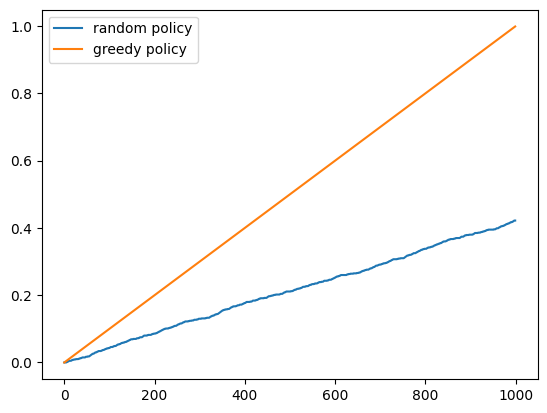

In [48]:
torch.manual_seed(40)
random.seed(40)
np.random.seed(40)
backwardagent = BackwardAgent()
backwardagent.random_baseline(number_of_episodes=1000, start=0, end=0)
backwardagent.train(number_of_episodes=1000, start=0, end=0)

In [52]:
for i in range(10):
  print(f"{i}:")
  backwardagent = BackwardAgent()
  backwardagent.train(number_of_episodes=250, start=1, end=1, plot=False)
  backwardagent.random_baseline(number_of_episodes=100, start=1, end=1, plot=False)

0:


100%|██████████| 250/250 [00:13<00:00, 18.43it/s]


in[1, 1] greedy policy solved: 0.936, 234/250


100%|██████████| 100/100 [00:01<00:00, 57.86it/s]


in [1, 1] random policy solved: 0.6, 60/100
1:


100%|██████████| 250/250 [00:32<00:00,  7.69it/s]


in[1, 1] greedy policy solved: 0.84, 210/250


100%|██████████| 100/100 [00:00<00:00, 102.10it/s]


in [1, 1] random policy solved: 0.58, 58/100
2:


100%|██████████| 250/250 [00:10<00:00, 23.66it/s]


in[1, 1] greedy policy solved: 0.992, 248/250


100%|██████████| 100/100 [00:01<00:00, 56.85it/s]


in [1, 1] random policy solved: 0.48, 48/100
3:


100%|██████████| 250/250 [00:14<00:00, 17.64it/s]


in[1, 1] greedy policy solved: 0.912, 228/250


100%|██████████| 100/100 [00:01<00:00, 72.59it/s]


in [1, 1] random policy solved: 0.58, 58/100
4:


100%|██████████| 250/250 [00:34<00:00,  7.34it/s]


in[1, 1] greedy policy solved: 0.728, 182/250


100%|██████████| 100/100 [00:01<00:00, 95.23it/s]


in [1, 1] random policy solved: 0.47, 47/100
5:


100%|██████████| 250/250 [00:11<00:00, 22.24it/s]


in[1, 1] greedy policy solved: 0.964, 241/250


100%|██████████| 100/100 [00:01<00:00, 91.95it/s]


in [1, 1] random policy solved: 0.55, 55/100
6:


100%|██████████| 250/250 [00:11<00:00, 20.91it/s]


in[1, 1] greedy policy solved: 0.968, 242/250


100%|██████████| 100/100 [00:00<00:00, 101.48it/s]


in [1, 1] random policy solved: 0.57, 57/100
7:


100%|██████████| 250/250 [00:14<00:00, 16.92it/s]


in[1, 1] greedy policy solved: 0.928, 232/250


100%|██████████| 100/100 [00:01<00:00, 57.87it/s]


in [1, 1] random policy solved: 0.59, 59/100
8:


100%|██████████| 250/250 [00:15<00:00, 15.70it/s]


in[1, 1] greedy policy solved: 0.856, 214/250


100%|██████████| 100/100 [00:01<00:00, 92.27it/s]


in [1, 1] random policy solved: 0.43, 43/100
9:


100%|██████████| 250/250 [00:11<00:00, 21.80it/s]


in[1, 1] greedy policy solved: 0.96, 240/250


100%|██████████| 100/100 [00:01<00:00, 98.04it/s]

in [1, 1] random policy solved: 0.45, 45/100


100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


in[1, 1] greedy policy solved: 0.91, 91/100
[1.0, 0, 0.81, 1.0, 1]
[1.0, 0, 0.81, 1.0, 1]
[0.5, 0, 0.81, 0.9, 2]
[0.5, 1, 0.81, 0.9, 2]
[0.5, 0, 0.81, 0.9, 2]
[0.0, 0, 0.81, 0.81, 2]
####::
#@*#::
#  ###
#*   #
#    #
#  ###
####::
####::
# *#::
#@ ###
#*   #
#    #
#  ###
####::
####::
# *#::
# @###
#*   #
#    #
#  ###
####::
####::
# .#::
# $###
#*@  #
#    #
#  ###
####::
####::
# .#::
#  ###
#*$  #
# @  #
#  ###
####::
####::
# .#::
#  ###
#*$  #
#@   #
#  ###
####::


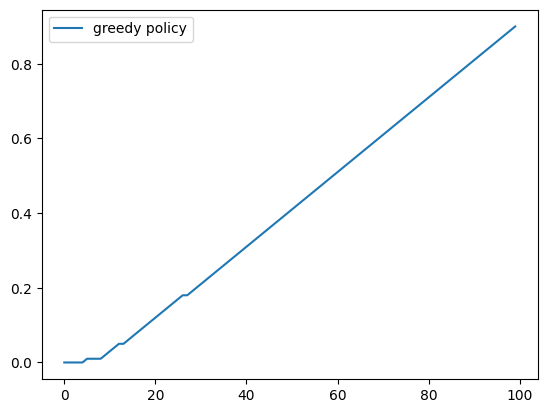

In [49]:
torch.manual_seed(40)
random.seed(40)
np.random.seed(40)
backwardagent = BackwardAgent()
backwardagent.train(number_of_episodes=100, start=1, end=1)
env = game.ReverseGame(game.Game(level_id=1), disable_prints=True)
boards, packing_order = backwardagent.backward_trajectory(env)
BackwardAgent.print_trajectory(boards)